By\
Nisarg Patel\
Dharmik Kakadiya

# CSCN8020 Final Project DNQ Implementation

In [1]:
import gym
import warnings
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import matplotlib.pyplot as plt

# Filter out warning messages to keep the output clean
warnings.filterwarnings('ignore')

In [2]:
# Initialize the FrozenLake-v1 environment with a slippery surface
env = gym.make('FrozenLake-v1', is_slippery=True)
n_states = env.observation_space.n
n_actions = env.action_space.n

In [3]:
# Define the Deep Q-Network (DQN) model
class DQN(nn.Module):
    def __init__(self, n_states, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_states, 64)
        self.fc2 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
# Hyperparameters
EPISODES = 2000
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
BUFFER_SIZE = 10000
TARGET_UPDATE = 10

# Initialize the DQN model, target network, optimizer, and replay buffer
model = DQN(n_states, n_actions)
target_model = DQN(n_states, n_actions)
target_model.load_state_dict(model.state_dict())
optimizer = optim.Adam(model.parameters())
replay_buffer = deque(maxlen=BUFFER_SIZE)

In [5]:
# Function to perform one-hot encoding of the state
def one_hot_encode(state, n_states):
    one_hot = torch.zeros(n_states)
    one_hot[state] = 1.0
    return one_hot

In [6]:
# List to store episode rewards for plotting
episode_rewards = []

In [7]:
# DQN training loop
for episode in range(EPISODES):
    state = env.reset()
    episode_reward = 0
    eps = EPS_END + (EPS_START - EPS_END) * np.exp(-1 * episode / EPS_DECAY)

    while True:
        # Choose action using epsilon-greedy policy
        if np.random.rand() < eps:
            action = env.action_space.sample()
        else:
            state_tensor = one_hot_encode(state, n_states)
            q_values = model(state_tensor)
            action = torch.argmax(q_values).item()

        # Take action and get next state, reward, and done flag
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward

        # Store experience in replay buffer
        replay_buffer.append((state, action, reward, next_state, done))

        # Sample a batch from the replay buffer
        if len(replay_buffer) >= BATCH_SIZE:
            batch = np.random.choice(len(replay_buffer), BATCH_SIZE, replace=False)
            states, actions, rewards, next_states, dones = zip(*[replay_buffer[i] for i in batch])

            states_tensor = torch.stack([one_hot_encode(s, n_states) for s in states])
            actions_tensor = torch.tensor(actions, dtype=torch.int64)
            rewards_tensor = torch.tensor(rewards, dtype=torch.float32)
            next_states_tensor = torch.stack([one_hot_encode(s, n_states) for s in next_states])
            dones_tensor = torch.tensor(dones, dtype=torch.uint8)

            # Compute the Q-values for the current states
            q_values = model(states_tensor).gather(1, actions_tensor.unsqueeze(1)).squeeze()

            # Compute the target Q-values for the next states
            next_q_values = target_model(next_states_tensor).max(1)[0].detach()
            target_q_values = rewards_tensor + GAMMA * next_q_values * (1 - dones_tensor)

            # Compute the loss and update the model
            loss = nn.MSELoss()(q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Update the target network
        if episode % TARGET_UPDATE == 0:
            target_model.load_state_dict(model.state_dict())

        state = next_state

        if done:
            episode_rewards.append(episode_reward)
            print(f"Episode: {episode + 1}, Reward: {episode_reward}, Epsilon: {eps:.3f}")
            break

Episode: 1, Reward: 0.0, Epsilon: 0.900
Episode: 2, Reward: 0.0, Epsilon: 0.896
Episode: 3, Reward: 0.0, Epsilon: 0.892
Episode: 4, Reward: 0.0, Epsilon: 0.887
Episode: 5, Reward: 0.0, Epsilon: 0.883
Episode: 6, Reward: 0.0, Epsilon: 0.879
Episode: 7, Reward: 0.0, Epsilon: 0.875
Episode: 8, Reward: 0.0, Epsilon: 0.871
Episode: 9, Reward: 0.0, Epsilon: 0.867
Episode: 10, Reward: 0.0, Epsilon: 0.863
Episode: 11, Reward: 0.0, Epsilon: 0.859
Episode: 12, Reward: 0.0, Epsilon: 0.855
Episode: 13, Reward: 0.0, Epsilon: 0.850
Episode: 14, Reward: 0.0, Epsilon: 0.847
Episode: 15, Reward: 0.0, Epsilon: 0.843
Episode: 16, Reward: 0.0, Epsilon: 0.839
Episode: 17, Reward: 0.0, Epsilon: 0.835
Episode: 18, Reward: 0.0, Epsilon: 0.831
Episode: 19, Reward: 0.0, Epsilon: 0.827
Episode: 20, Reward: 0.0, Epsilon: 0.823
Episode: 21, Reward: 0.0, Epsilon: 0.819
Episode: 22, Reward: 0.0, Epsilon: 0.815
Episode: 23, Reward: 0.0, Epsilon: 0.811
Episode: 24, Reward: 0.0, Epsilon: 0.808
Episode: 25, Reward: 0.0,

In [17]:
# Test the trained model
test_episodes = 10
total_reward = 0

for episode in range(test_episodes):
    state = env.reset()
    episode_reward = 0

    while True:
        state_tensor = one_hot_encode(state, n_states)
        q_values = model(state_tensor)
        action = torch.argmax(q_values).item()

        next_state, reward, done, _ = env.step(action)
        episode_reward += reward
        state = next_state

        if done:
            total_reward += episode_reward
            print(f"Test Episode: {episode + 1}, Reward: {episode_reward}")
            break

print(f"Average Reward: {total_reward / test_episodes}")

Test Episode: 1, Reward: 1.0
Test Episode: 2, Reward: 1.0
Test Episode: 3, Reward: 1.0
Test Episode: 4, Reward: 1.0
Test Episode: 5, Reward: 0.0
Test Episode: 6, Reward: 1.0
Test Episode: 7, Reward: 1.0
Test Episode: 8, Reward: 1.0
Test Episode: 9, Reward: 1.0
Test Episode: 10, Reward: 0.0
Average Reward: 0.8


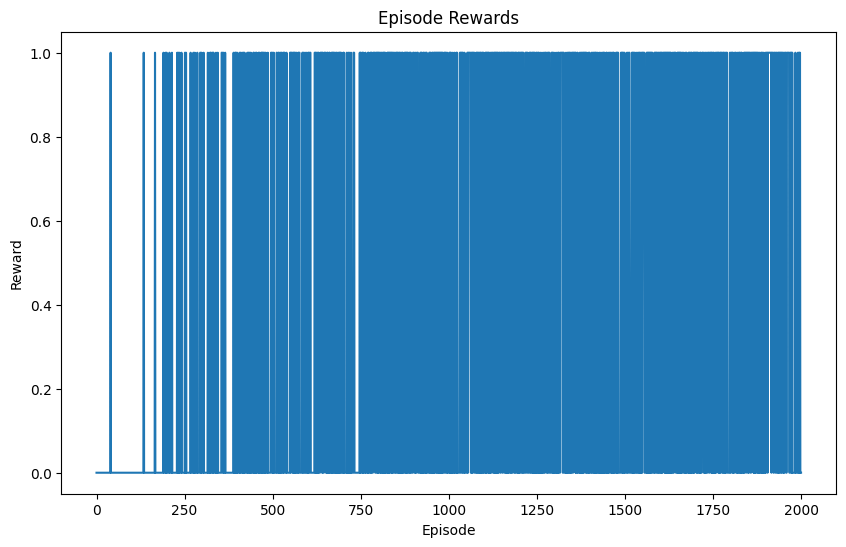

In [21]:
import matplotlib.pyplot as plt

# Plot the episode rewards
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards)
plt.title("Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()